In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from pydmd import DMD
from skimage.util import random_noise

In [2]:
def saliency_detect(img):
    
    # Converting RGB Colorspace to YUV Colorspace
    img_YUV = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    Y1,U,V = cv2.split(img_YUV)

    # Converting RGB Colorspace to LAB Colorspace
    img_LAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    L,a,b = cv2.split(img_LAB)

    # Converting RGB Colorspace to LAB Colorspace
    img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    Y2, Cr, Cb = cv2.split(img_YCrCb)

    # ------ Computing Color based saliency map -------

    # Vectoring the color space channels
    a_vec = a.reshape([a.shape[0]*a.shape[1],1])
    b_vec = b.reshape([b.shape[0]*b.shape[1],1])
    U_vec = U.reshape([U.shape[0]*U.shape[1],1])
    V_vec = V.reshape([V.shape[0]*V.shape[1],1])
    Cr_vec = Cr.reshape([Cr.shape[0]*Cr.shape[1],1])
    Cb_vec = Cb.reshape([Cb.shape[0]*Cb.shape[1],1])
    D1_vec = b_vec + V_vec + Cr_vec
    D2_vec = a_vec + U_vec + Cb_vec

    # Static image representation for DMD
    X1 = np.concatenate ((b_vec,V_vec,Cr_vec,D1_vec,V_vec,Cr_vec,b_vec,D1_vec,D1_vec,Cr_vec,V_vec,b_vec,V_vec,Cr_vec,D1_vec,b_vec,V_vec,b_vec,D1_vec,Cr_vec),axis=1)
    X2 = np.concatenate((a_vec,U_vec,Cb_vec,D2_vec,U_vec,Cb_vec,a_vec,D2_vec,D2_vec,Cb_vec,U_vec,a_vec,U_vec,Cb_vec,D2_vec,a_vec,U_vec,a_vec,D2_vec,Cb_vec),axis=1)

    # Performing DMD on the above matrices
    dmd1 = DMD(svd_rank=3)
    dmd1.fit(X1)

    dmd2 = DMD(svd_rank=3)
    dmd2.fit(X2)

    # Computing the DMD Modes
    Phi1 = dmd1.modes
    Phi2 = dmd2.modes

    # Seperating the low rank and sparse components
    # Intermediate singular values represent salient part of an image while smaller and larger values represent non-salient parts
    X_lowRank1 = np.concatenate((Phi1[:,0].reshape([Phi1.shape[0],1]),Phi1[:,5:len(X1)]),axis=1)
    X_sparse1 = Phi1[:,2:5]
    X_lowRank2 = np.concatenate((Phi2[:,0].reshape([Phi2.shape[0],1]),Phi2[:,5:len(X2)]),axis=1)
    X_sparse2 = Phi2[:,2:5]

    # Normalizing the low rank and sparse matrices
    X_lowRank_norm1 = (X_lowRank1 - np.min(X_lowRank1)) / (np.max(X_lowRank1)-np.min(X_lowRank1))
    X_sparse_norm1 = (X_sparse1 - np.min(X_sparse1)) / (np.max(X_sparse1)-np.min(X_sparse1))
    X_lowRank_norm2 = (X_lowRank2 - np.min(X_lowRank2)) / (np.max(X_lowRank2)-np.min(X_lowRank2))
    X_sparse_norm2 = (X_sparse2 - np.min(X_sparse2)) / (np.max(X_sparse2)-np.min(X_sparse2))

    # Generating the final sparse and low rank components
    X_sparse_out = X_sparse_norm1 + X_sparse_norm2
    X_lowRank_out = X_lowRank_norm1 + X_lowRank_norm2

    # Generating Saliency Map
    w = 0.1 # Weight
    SM_color_vec = np.real((X_sparse_out - w*X_lowRank_out)**2)

    # ------ Computing Luminance based saliency map -------

    # Computing Singular Value Decomposition to the 3 matrices (L, Y1, Y2) - Luminance Components
    u_L, s_L, vh_L = np.linalg.svd(L, full_matrices=True)
    u_Y1, s_Y1, vh_Y1 = np.linalg.svd(Y1, full_matrices=True)
    u_Y2, s_Y2, vh_Y2 = np.linalg.svd(Y2, full_matrices=True)

    # Reconstruction of luminance data matrices using n intermediate singular values

    n = 3 # Number of singular values taken

    # Range of the singular values taken
    r1 = int(u_L.shape[0]/2) # Starting range
    r2 = r1 + n # Ending range

    # Reconstructed data matrices
    L_rec= u_L[:,r1:r2]@np.diag(s_L[r1:r2])@vh_L[r1:r2,:] 
    Y1_rec = u_Y1[:,r1:r2]@np.diag(s_Y1[r1:r2])@vh_Y1[r1:r2,:] 
    Y2_rec = u_Y2[:,r1:r2]@np.diag(s_Y2[r1:r2])@vh_Y2[r1:r2,:] 

    # Vectorize the reconstructed data matrices
    L_rec_vec = L_rec.reshape([L_rec.shape[0]*L_rec.shape[1],1])
    Y1_rec_vec = Y1_rec.reshape([Y1_rec.shape[0]*Y1_rec.shape[1],1])
    Y2_rec_vec = Y2_rec.reshape([Y2_rec.shape[0]*Y2_rec.shape[1],1])

    # Generating data matrix that is to be fed into the DMD
    X = np.concatenate((L_rec_vec,Y1_rec_vec,Y2_rec_vec,L_rec_vec,Y2_rec_vec,Y1_rec_vec,Y1_rec_vec,L_rec_vec,Y2_rec_vec,Y2_rec_vec,L_rec_vec,Y1_rec_vec,Y2_rec_vec,Y1_rec_vec,L_rec_vec,Y1_rec_vec,Y2_rec_vec,L_rec_vec),axis=1)

    # Performing DMD for the permutated columns
    dmd = DMD(svd_rank=3)
    dmd.fit(X)

    # Computing the DMD Modes
    Phi = dmd.modes

    # Seperating the low rank and sparse components
    # Intermediate singular values represent salient part of an image while smaller and larger values represent non-salient parts
    X_lowRank = np.concatenate((Phi[:,0].reshape([Phi.shape[0],1]),Phi[:,3:len(X)]),axis=1)
    X_sparse = Phi[:,2:len(X)]

    # Normalizing the sparse matrix and low rank matrix
    X_lowRank_norm = (X_lowRank - np.min(X_lowRank)) / (np.max(X_lowRank)-np.min(X_lowRank))
    X_sparse_norm = (X_sparse - np.min(X_sparse)) / (np.max(X_sparse)-np.min(X_sparse))

    # --------- Generating Saliency Map ----------------
    W = 0 # Weight - Always zero as luminance based saliency map takes only sparse component of DMD
    SM_luminous_vec = np.real((X_sparse_norm - W*X_lowRank_norm)**2)

    SM_final_vec = []
    for i in range(len(SM_luminous_vec)):
        SM_final_vec.append(max(SM_luminous_vec[i],SM_color_vec[i]))
    SM_final = np.array(SM_final_vec).reshape([img.shape[0],img.shape[1]])
    
    # Creating a binary mask
    threshhold = 0.5
    binary_mask = np.zeros((SM_final.shape[0],SM_final.shape[1]),dtype=int)
    for i in range(SM_final.shape[0]):
        for j in range(SM_final.shape[1]):
            if SM_final[i,j] > threshhold:
                binary_mask[i,j] = 1
            else:
                binary_mask[i,j] = 0
                
    return binary_mask


<h1><center>Statistical Measures</center></h1>

In [3]:
# Precision Recall Function
def PR_score(salient_img,gt_sample):
    total_salient_pixels = (salient_img == 1).sum()
    total_groundTruth_pixels = (gt_sample == 255).sum()
    TP = 0 # True Positive 
    for i in range(salient_img.shape[0]):
        for j in range(salient_img.shape[1]):
            if salient_img[i,j].any() == gt_sample[i,j].any():
                TP += 1
    precision = TP/total_salient_pixels
    recall = TP/total_groundTruth_pixels
    return precision, recall

In [4]:
# F-Measure function
def F_score(precision,recall):
    beta_2 = 0.3 # Set as 0.3 to give more weight to precision than recall
    F_measure = ((1 + beta_2) * precision * recall) / (beta_2 * (precision + recall))
    return F_measure

In [5]:
# Generation of Binary Mask
def binary_mask(img): 
    threshhold = 0.75
    binary_mask = np.zeros((img.shape[0],img.shape[1]),dtype=int)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j].any() > threshhold:
                binary_mask[i,j] = 1
            else:
                binary_mask[i,j] = 0 
    return binary_mask

In [6]:
# Mean Absolute Error
def MAE(gt_bin,salient_img_bin):
    W = gt_bin.shape[1]
    H = gt_bin.shape[0]
    mae = np.sum(np.sqrt(np.abs((salient_img - gt_bin)**2)))/(W*H)
    return mae

In [7]:
# Confusion Matrix

def confusion_matrix(salient_image,gt_binary):
    
    FP = 0 # False Positve
    TP = 0 # True Positive
    TN = 0 # True Negative
    FN = 0 # False Negative
    
    for i in range(salient_img.shape[0]):
        for j in range(salient_img.shape[1]):
            if salient_img[i,j] == 1 and gt_binary[i,j] == 1:
                TP += 1
            elif salient_img[i,j] == 1 and gt_binary[i,j] == 0:
                FP += 1
            elif salient_img[i,j] == 0 and gt_binary[i,j] == 1:
                FN += 1   
            else:
                TN += 1
            
    confusion_matrix = np.array([[TP,FP],[FN,TN]])
    
    return confusion_matrix

In [8]:
# Receiver Operating Charecteristics - ROC Curve

def conf_mat_rates(conf_mat):
    TP = conf_mat[0,0]
    FP = conf_mat[0,1]
    FN = conf_mat[1,0]
    TN = conf_mat[1,1]
    TPR = TP / (TP + FN) # True Positive Rate
    FPR = FP / (FP +TN) # False Positive Rate
    FNR = FN / (FN + TP) # False Negative Rate
    TNR = TN / (TN + FP) # True Negative Rate
    return FPR, TPR, FNR, TNR

In [9]:
# # Summarizing all the Statistical Measures together

# def metrices(salient_img,gt_sample):
    
#     # Precision - recall
#     PR = PR_score(salient_img,gt_sample)
#     precision,recall = PR[0], PR[1]
    
#     # F-Measure
#     f_score = F_score()
    
#     # Mean Absolute Error
#     gt_bin = binary_mask(gt_sample)
#     mean_abs_err = MAE(gt_bin,salient_img)
    
#     # Confusion Matrix
#     conf_mat = confusion_matrix(salient_img, gt_bin)
    
#     rates = conf_mat_rates(conf_mat)
#     # ROC Values
#     FPR = rates[0] # False Positive Rate
#     TPR = rates[1] # True Positive Rate
#     roc_values = [FPR,TPR]
    
#     # Accuracy
#     FNR = rates[2]
#     TNR = rates[3]
#     accuracy = (TNR + TPR)/2
    
#     return precision,recall,f_score,mean_abs_err,conf_mat,roc_values,accuracy

# metrics = metrices(salient_img,gt_sample)
# precision,recall,F_score,mean_abs_err,conf_mat,roc_values,accuracy = metrics[0], metrics[1], metrics[2], metrics[3], metrics[4], metrics[5], metrics[6]
# print('''
# Precision:{0}\n
# Recall:{1}\n
# F-Score:{2}\n
# MAE:{3}\n
# Confusion Matrix:\n{4}
# \nROC:{5}\n
# Accuracy:{6}
# '''.format(precision,recall,F_score,mean_abs_err,conf_mat,roc_values,accuracy))

In [10]:
import os

im = "C:\\Users\\HP\\Semester V Codes\\End Semester Project\\MIS + SIP\\final_images"
g_t = "C:\\Users\\HP\\Semester V Codes\\End Semester Project\\MIS + SIP\\final_gt_mask"

C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 1.6525745647181934e+46. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 1.577318085980245e+48. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 4.460722238085769e+79. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


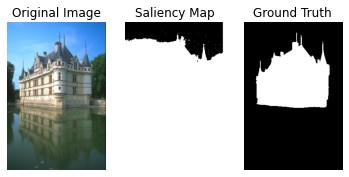

Confusion Matrix:
 [[26473 63508]
 [   27 16792]]


C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 3.486878263268494e+49. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 3.5115975333365237e+47. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 1.0417686532174807e+82. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


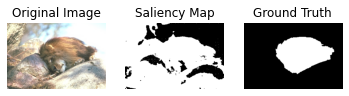

Confusion Matrix:
 [[21807 51631]
 [ 1396 31966]]


C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 2.2081101471426652e+48. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 7.973130535369457e+48. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 8.041861932813254e+79. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


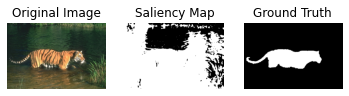

Confusion Matrix:
 [[14033 64411]
 [   96 28260]]


C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 5.042529805859909e+46. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 4.685781061479686e+46. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 4.044599711055075e+67. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


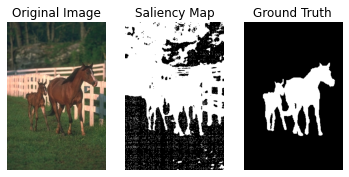

Confusion Matrix:
 [[16024 40633]
 [  787 49356]]


C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 3.884131000354311e+47. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 7.01529199279173e+48. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 3.4072127517598e+67. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


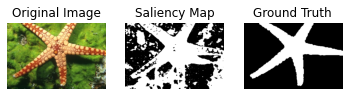

Confusion Matrix:
 [[25004 31637]
 [ 1894 48265]]


C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 4.7561698929554195e+47. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 3.3031881148187325e+46. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 3.200425381710007e+67. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


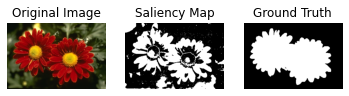

Confusion Matrix:
 [[32441  8526]
 [14253 51580]]


C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 3.3083348997356833e+47. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 3.3925601456039247e+47. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 6.034264244220402e+79. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


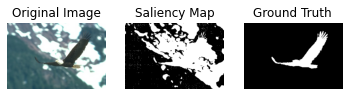

Confusion Matrix:
 [[ 7547 35073]
 [  631 63549]]


C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 1.2359563707215387e+47. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 2.6600841538957943e+46. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 1.9981431213252842e+85. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


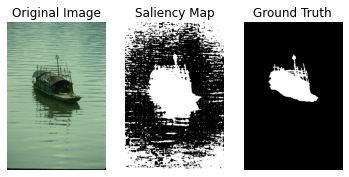

Confusion Matrix:
 [[ 7955 38884]
 [   50 59911]]


C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 1.6087488007221276e+47. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 2.8344864707885523e+46. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 1.0047751593160346e+68. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


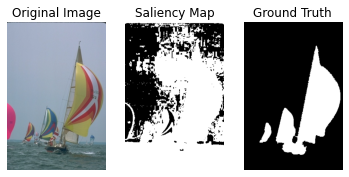

Confusion Matrix:
 [[21668 48075]
 [  841 36216]]


C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 3.7089934827711857e+46. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 2.5152437644029595e+46. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 1.2905527587427329e+68. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


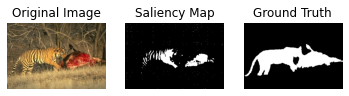

Confusion Matrix:
 [[ 6056   204]
 [14275 86265]]


C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 3.047886451164068e+48. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 5.512440493171242e+47. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 9.174373631946799e+67. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


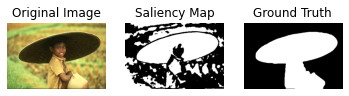

Confusion Matrix:
 [[30825 22379]
 [12935 40661]]


C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 1.1700406468645483e+48. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 4.15486169380877e+47. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 2.949912522935544e+68. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


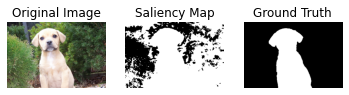

Confusion Matrix:
 [[26554 47837]
 [    0 32009]]


C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 2.067379348648572e+49. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 5.3071354311302584e+48. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 6.036953638180265e+67. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


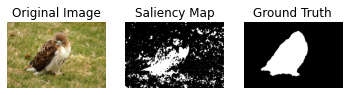

Confusion Matrix:
 [[10854  9275]
 [ 8475 77796]]


C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 5.816155228671317e+47. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 2.4426828697141686e+48. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 5.883571173226885e+97. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


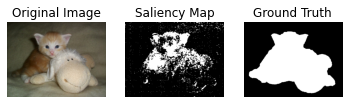

Confusion Matrix:
 [[18839  1900]
 [31326 68735]]


C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 9.083949452056069e+49. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 5.497882792793365e+47. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 2.4853644679363833e+80. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


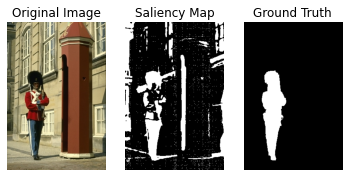

Confusion Matrix:
 [[ 6311 15304]
 [ 2976 82209]]


C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 1.4140653047513863e+48. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 4.573544854374063e+48. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 1.5045389138238688e+82. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


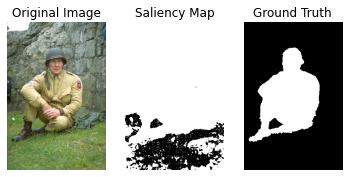

Confusion Matrix:
 [[26667 61774]
 [    4 18355]]


C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 7.1528215325618274e+47. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 4.548068293151362e+48. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 5.624503855924228e+68. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


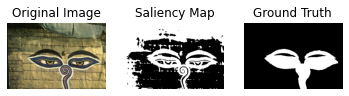

Confusion Matrix:
 [[14423 38830]
 [ 4645 48902]]


C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 3.170929268473796e+48. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 3.5172359532714804e+48. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 2.5657620508985412e+67. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


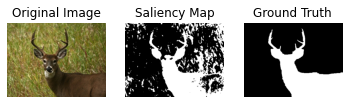

Confusion Matrix:
 [[26280 15709]
 [ 5288 72723]]


C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 6.467685939137272e+47. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 7.91467428122262e+47. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 3.821579447845127e+69. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


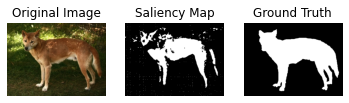

Confusion Matrix:
 [[21529  1568]
 [14936 80367]]


C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 2.184408023355187e+47. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 1.3336009999021889e+47. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 1.5974560422330914e+68. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


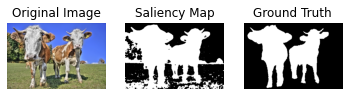

Confusion Matrix:
 [[38265 16532]
 [  148 51855]]


C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 3.028022110574541e+47. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 4.468573746036051e+48. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 6.69267893991186e+80. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


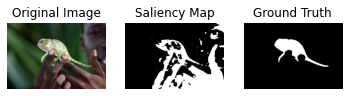

Confusion Matrix:
 [[ 4276 26150]
 [ 2875 73499]]


C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 6.688631218779308e+46. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 1.2645019797246718e+48. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 1.588727410125249e+79. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


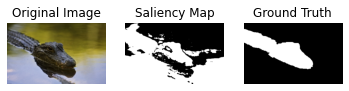

Confusion Matrix:
 [[14533 39450]
 [ 4374 40843]]


C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 2.555541209881425e+46. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 3.464971067573009e+48. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 4.420473770514068e+81. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


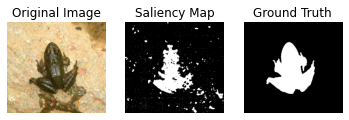

Confusion Matrix:
 [[ 14145   4070]
 [  8528 120057]]


C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 2.9185227320280386e+50. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 6.871226713760453e+49. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 7.577077120338466e+67. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


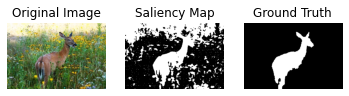

Confusion Matrix:
 [[11914 27657]
 [ 1336 65893]]


C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 4.137641272910053e+48. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 7.694645687209012e+48. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 1.802780537897391e+68. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


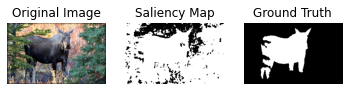

Confusion Matrix:
 [[21927 58194]
 [  168 18511]]


C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 1.5570007114623816e+47. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 2.0880536911099017e+48. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 7.556382931953009e+79. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


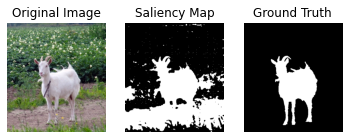

Confusion Matrix:
 [[19545 32515]
 [  901 91439]]


C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 1.514633494286835e+47. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 1.6126205391555493e+47. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 6.246203218554999e+66. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


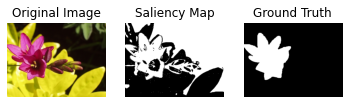

Confusion Matrix:
 [[15393 49175]
 [ 4395 51037]]


In [11]:
P = [] # Precision values
R = [] # Recall values
F = [] # F-measure values
Mean_Abs_Error = [] # Mean Absolute Error
ROC = [] # ROC values
ACC = [] # Accuracy values

for e,i in enumerate(os.listdir(im)):
    
    img = cv2.imread(os.path.join(im,i))  
    j=i[:-3]+"png"
    
    gt_sample = cv2.imread(os.path.join(g_t,j)) # Ground Truth Image
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Original Image
    salient_img = saliency_detect(image)  # Salient Image

    plt.subplot(1,3,1)
    plt.imshow(image) # RGB Image
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(salient_img,cmap="gray") # Salient Image
    plt.title('Saliency Map')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(gt_sample) # Ground Truth Image
    plt.title('Ground Truth')
    plt.axis('off')

    plt.show()

    # --------------- Statistical Analysis ---------------
    
    precision,recall = PR_score(salient_img,gt_sample)
    
    # F-Measure
    f_score = F_score(precision,recall)
    
    # Mean Absolute Error
    gt_bin = binary_mask(gt_sample)
    mean_abs_err = MAE(gt_bin,salient_img)
    
    # Confusion Matrix
    conf_mat = confusion_matrix(salient_img, gt_bin)
    print('Confusion Matrix:\n',conf_mat)
    
    rates = conf_mat_rates(conf_mat)
    # ROC Values
    FPR = rates[0] # False Positive Rate
    TPR = rates[1] # True Positive Rate
    roc_values = [FPR,TPR]
    
    # Accuracy
    FNR = rates[2]
    TNR = rates[3]
    accuracy = (TNR + TPR)/2
    
    P.append(precision)
    R.append(recall)
    F.append(f_score) 
    Mean_Abs_Error.append(mean_abs_err)
    ROC.append(roc_values)
    ACC.append(accuracy)
    

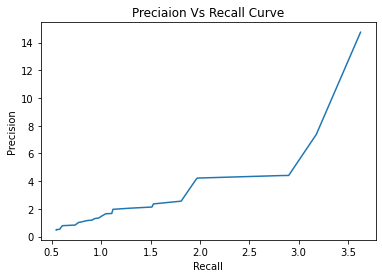

In [13]:
# Precision Vs Recall Curve
plt.plot(sorted(R),sorted(P)) # R - Recall ; P - Precision
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Preciaion Vs Recall Curve')
plt.show()

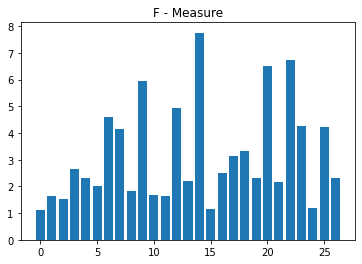

In [14]:
# F - Measure
plt.bar(np.arange(len(F)),F) # F - Measure
plt.title('F - Measure')
plt.show()

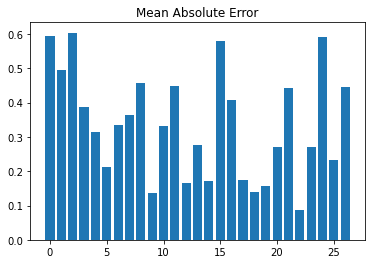

In [15]:
# Mean Absolute Error
plt.bar(np.arange(len(Mean_Abs_Error)),(Mean_Abs_Error))
plt.title('Mean Absolute Error')
plt.show()

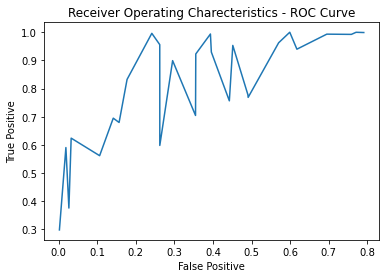

In [16]:
# ROC Curve
false_pos = np.array(sorted(ROC))[:,0]
true_pos = np.array(sorted(ROC))[:,1]
plt.plot(false_pos,true_pos)
plt.title('Receiver Operating Charecteristics - ROC Curve')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.show()

In [17]:
# AUC Measure
area = np.trapz(false_pos,true_pos)
print(area)

0.12684327319441407


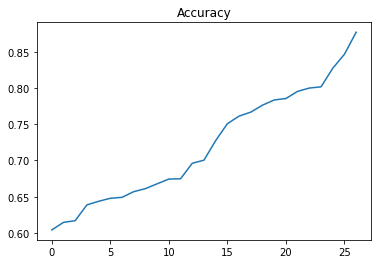

Maximum Accuracy: 87.7202643083137 %


In [18]:
# Accuracy
plt.plot(np.arange(len(ACC)),sorted(ACC))
plt.title('Accuracy')
plt.show()
print('Maximum Accuracy:',max(ACC)*100,'%')

In [134]:
# ------- For testing purpose - to get number of more accurate images -------- For our reference --------------- 
# cnt = 0
# for i in range(len(ACC)):
#     if ACC[i] > 0.60:
#         print(i,':',ACC[i])
#         cnt += 1
# print('----- total:',cnt,'------')